In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', '..', '..', '..', 'models')))

# Obliczanie odległości dla wybranych punktów

In [4]:
import numpy as np

LANDMARK_INDEXES = np.load(os.path.join('..', '..', '..', '..', 'data', 'landmarks', 'combined_selected_points_emotions.npy'))
REFERENCE_POINT_IDX = 0

In [5]:
from utils import load_data, convert_landmarks_to_distances

all_data, all_labels = load_data('ravdess')
all_data = convert_landmarks_to_distances(all_data, LANDMARK_INDEXES, REFERENCE_POINT_IDX, normalize=True)

In [6]:
import torch
from torch.nn.utils.rnn import pad_sequence

tensor_data = [torch.tensor(d, dtype=torch.float32) for d in all_data]
padded_data = pad_sequence(tensor_data, batch_first=True)

## Average normalized distances per label

In [7]:
average_distances_per_frame = torch.mean(padded_data, dim=2)

In [14]:
emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [19]:
avg_distances = []
for i in range(1, len(emotions) + 1):
    avg_distances.append(torch.mean(average_distances_per_frame[all_labels == i], dim=0))

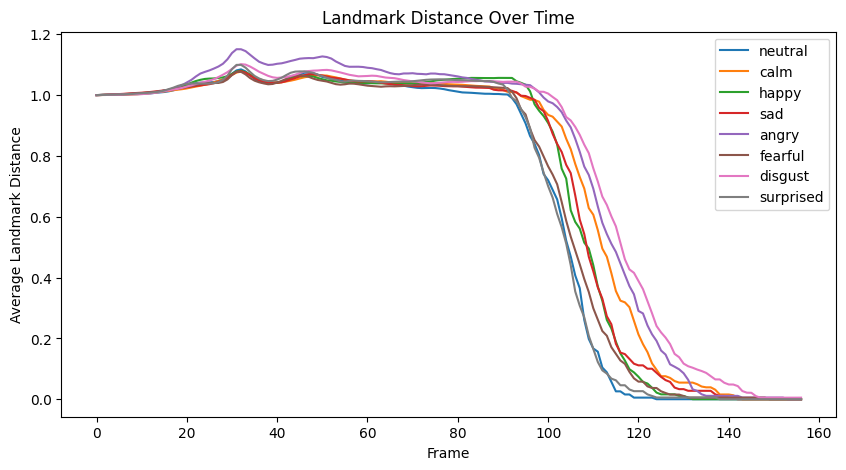

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for emotion, avg_distance in zip(emotions, avg_distances):
    plt.plot(avg_distance, label=emotion)

plt.xlabel('Frame')
plt.ylabel('Average Landmark Distance')
plt.title('Landmark Distance Over Time')
plt.legend()
plt.show()

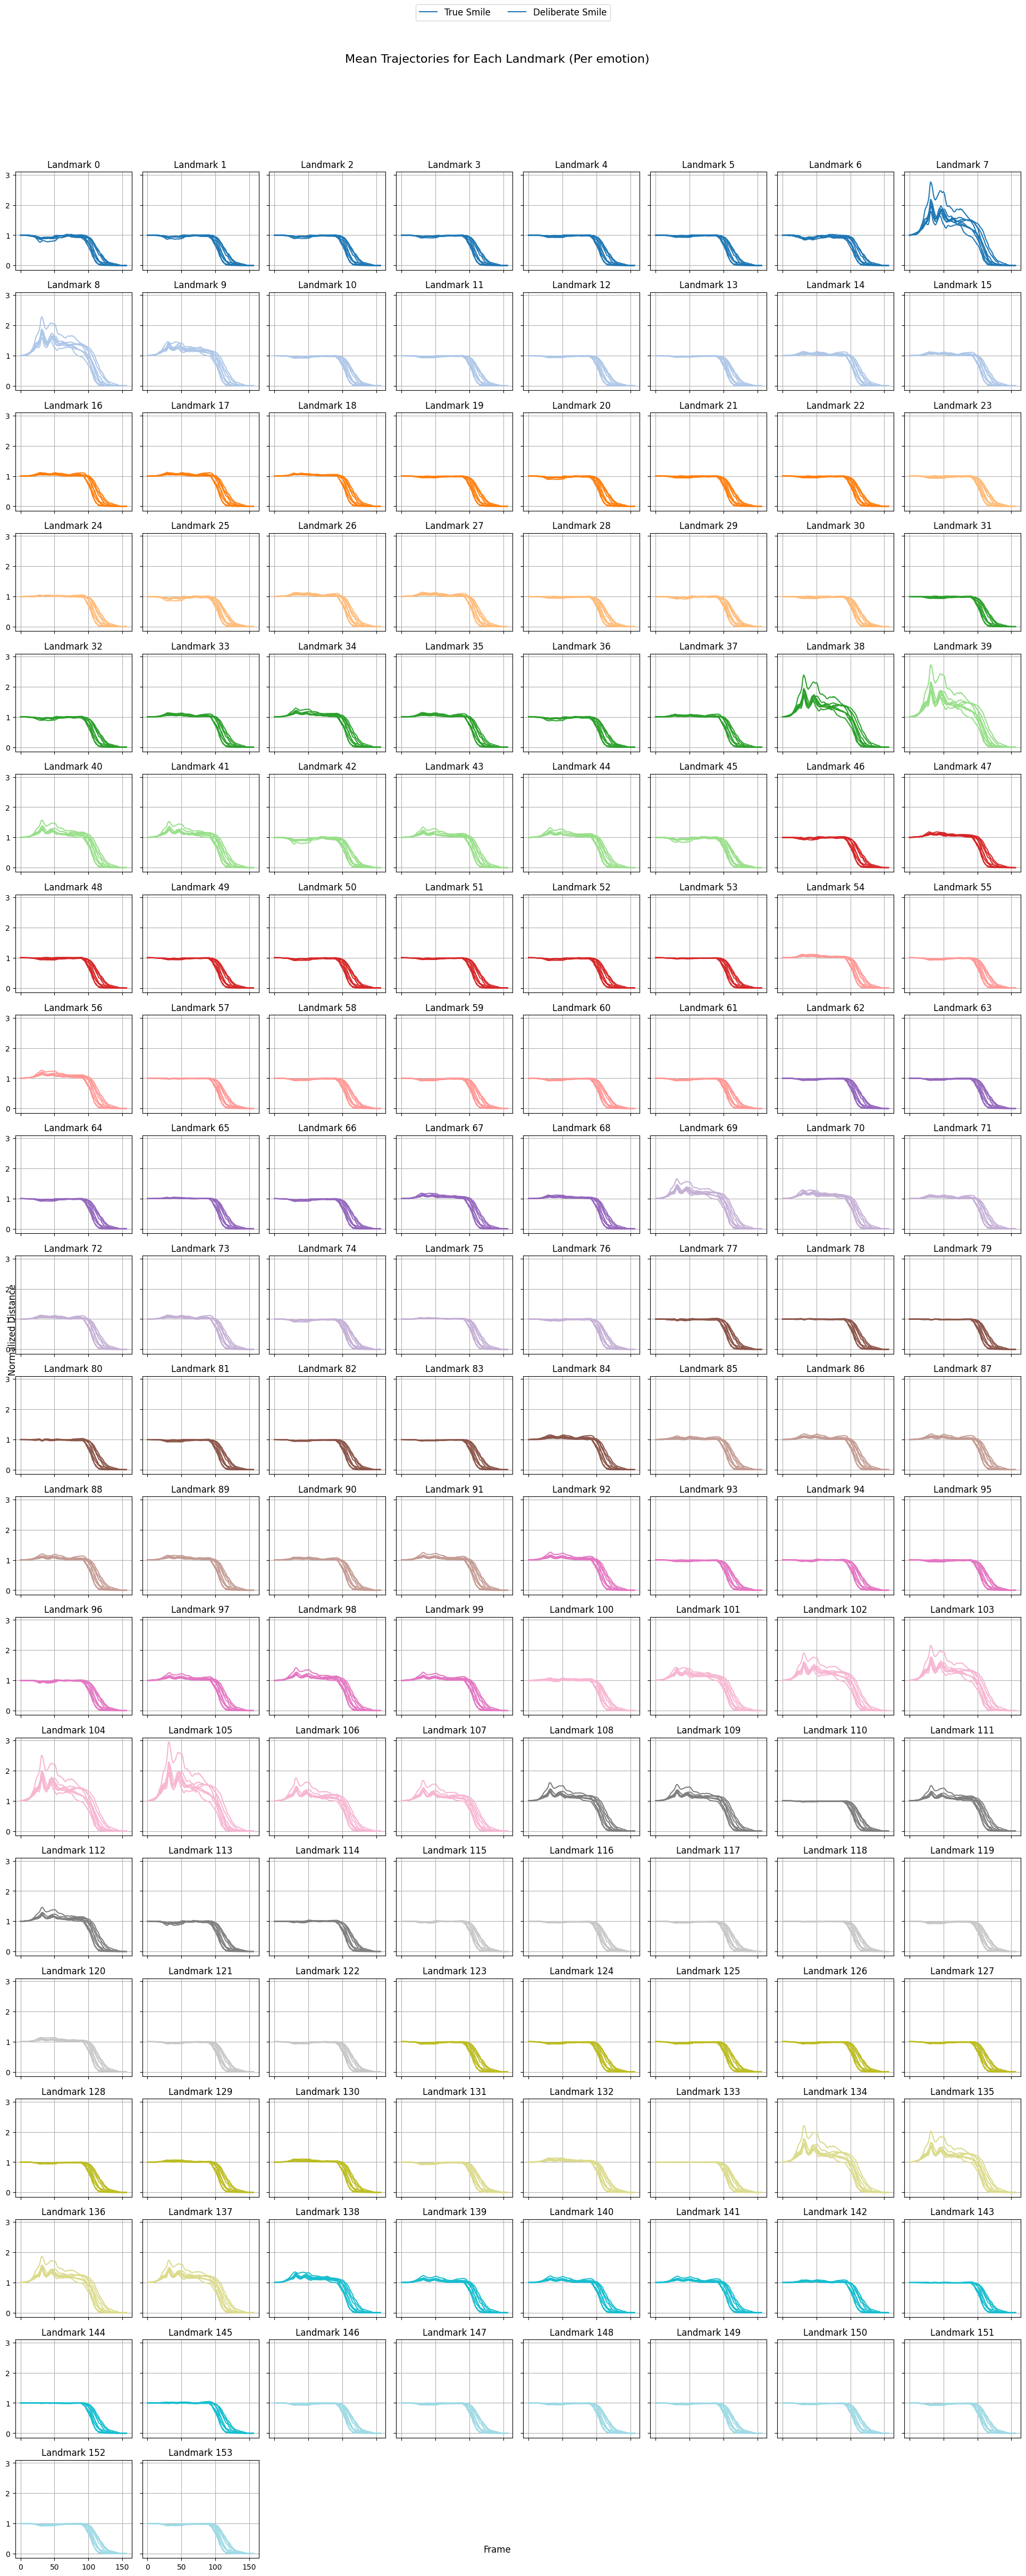

In [36]:
import numpy as np
import matplotlib.pyplot as plt

avg_distances_per_frame = []
for i in range(1, len(emotions) + 1):
    avg_distances_per_frame.append(torch.mean(padded_data[all_labels == i], dim=0))

# Plot all landmarks in a grid
n_landmarks = 154
n_cols = 8
n_rows = int(np.ceil(n_landmarks / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 2.5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

cmap = plt.get_cmap('tab20', n_landmarks)  # diverse colormap

for i in range(n_landmarks):
    ax = axes[i]
    color = cmap(i)
    for emotion, avg_distance in zip(emotions, avg_distances_per_frame):
        ax.plot(avg_distance[:, i], label=emotion, linestyle='-', color=color)
    ax.set_title(f'Landmark {i}')
    ax.grid(True)

# Hide unused subplots if any
for j in range(n_landmarks, len(axes)):
    axes[j].axis('off')

# Add legend only once
fig.legend(['True Smile', 'Deliberate Smile'], loc='upper center', ncol=2, fontsize='large')
fig.suptitle('Mean Trajectories for Each Landmark (Per emotion)', fontsize=16)
fig.text(0.5, 0.04, 'Frame', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Normalized Distance', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()


### One vs Rest difference

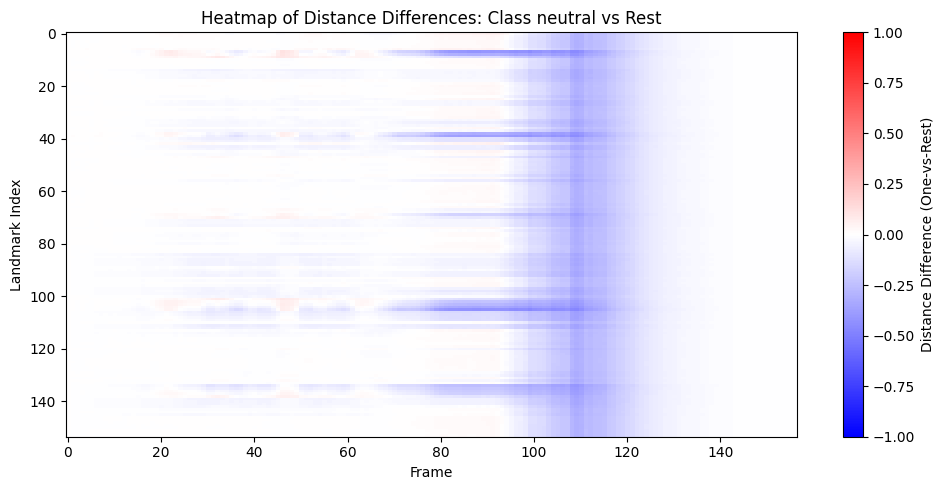

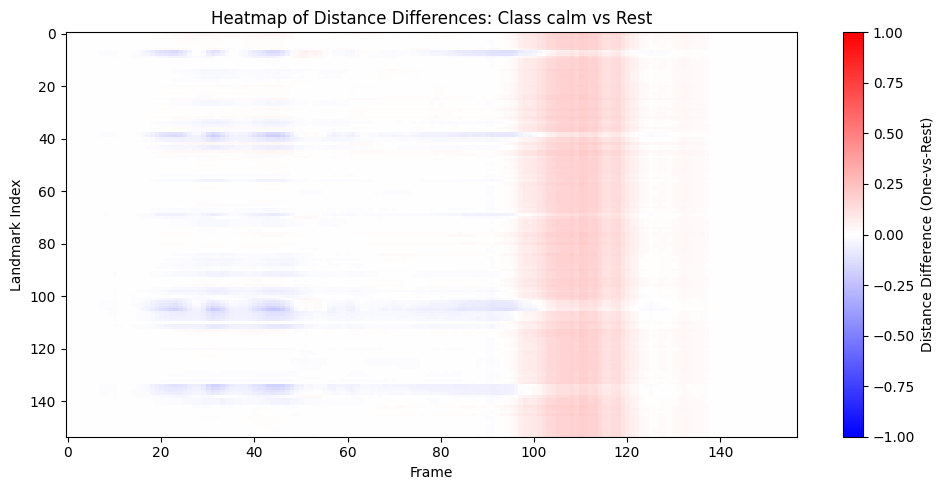

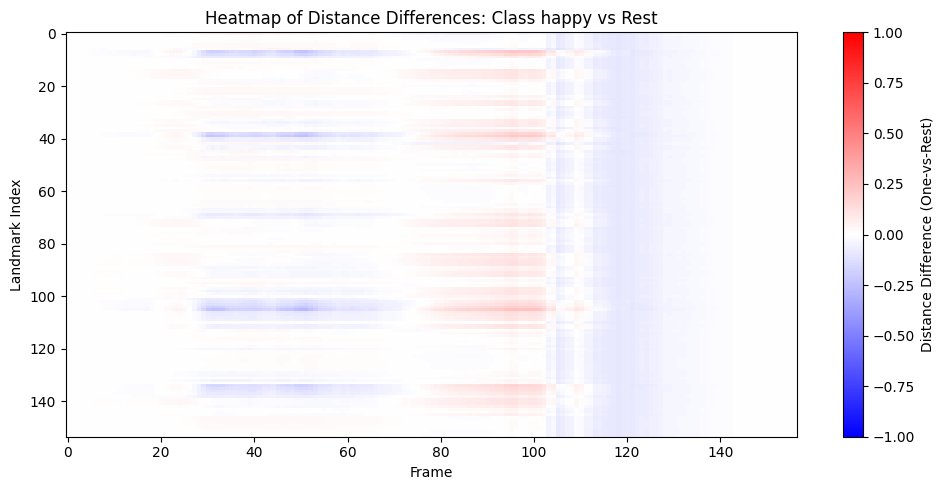

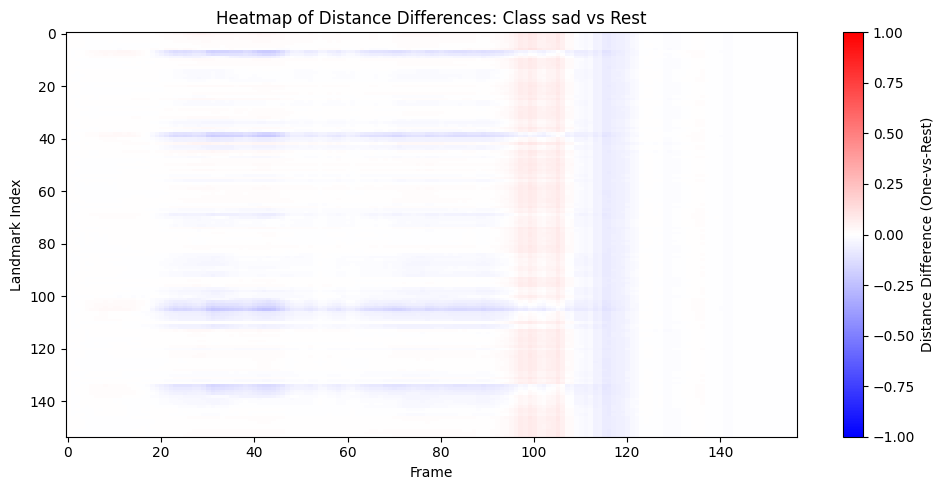

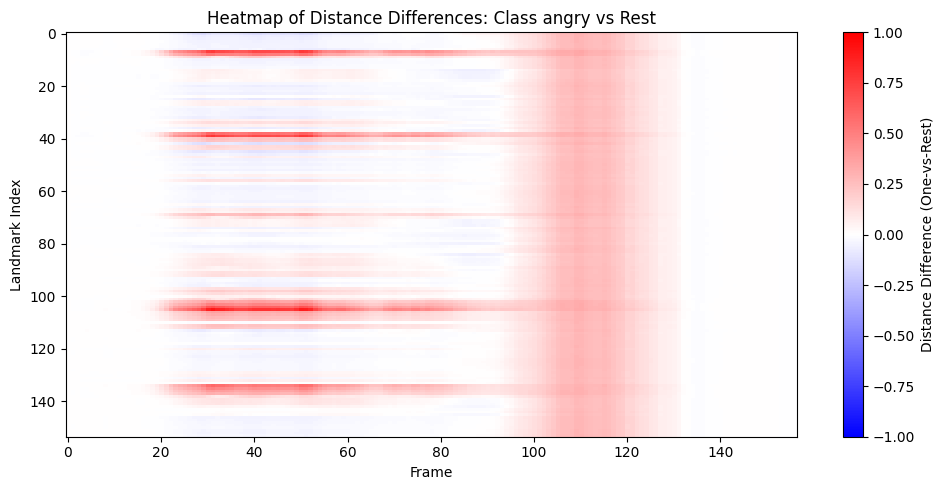

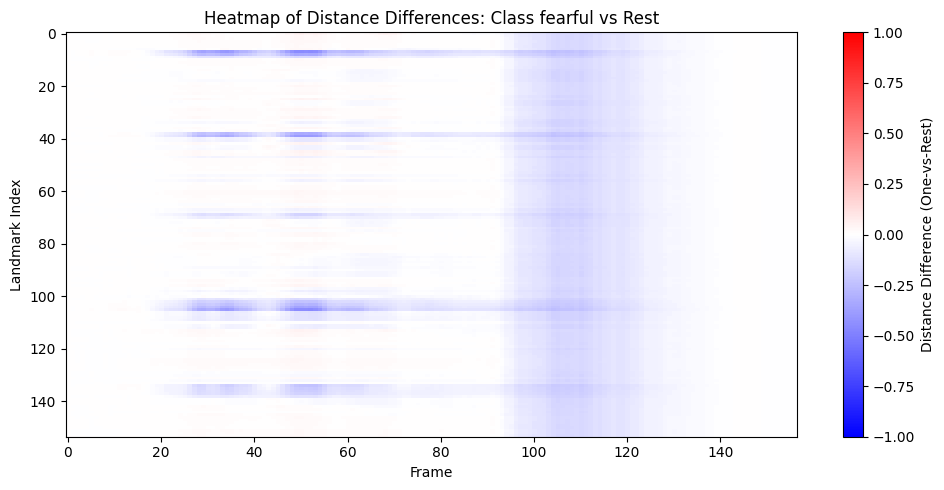

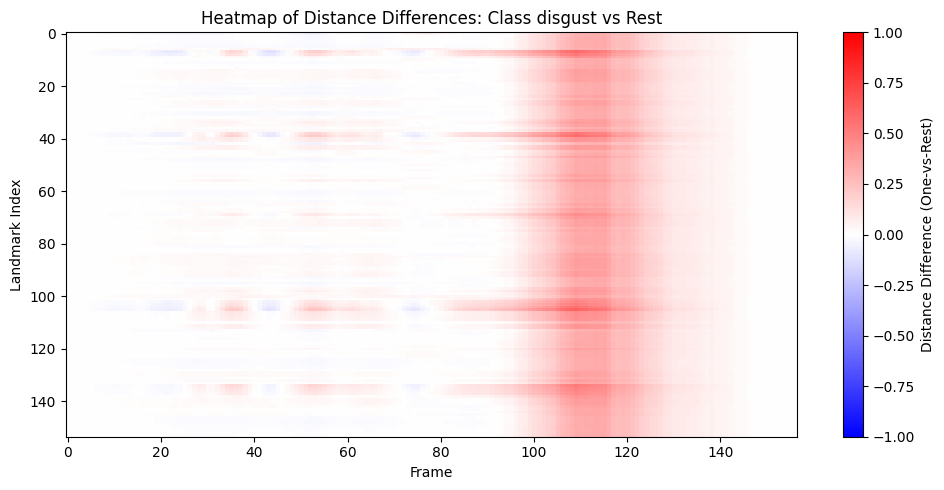

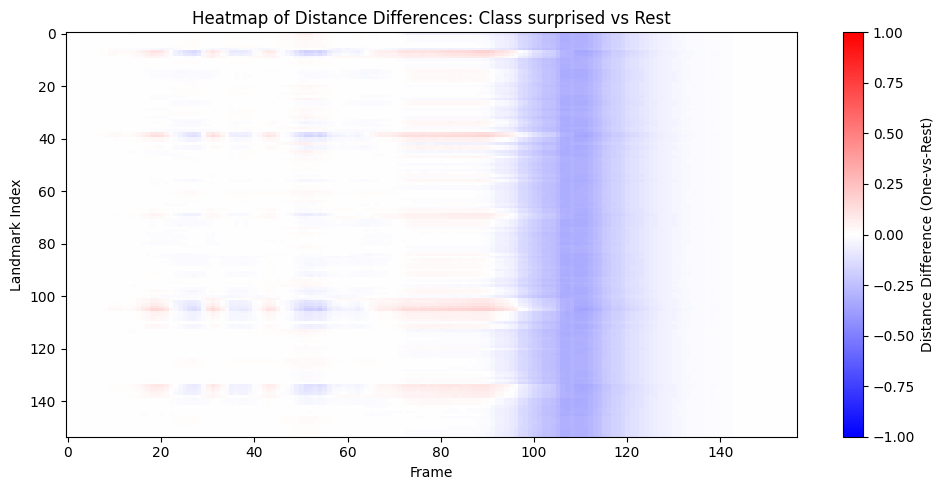

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

one_vs_rest_diffs = []

for i in range(len(emotions)):
    class_i = avg_distances_per_frame[i]
    rest = np.delete(avg_distances_per_frame, i, axis=0)
    rest_mean = rest.mean(axis=0)
    diff = class_i - rest_mean
    one_vs_rest_diffs.append((i, diff))

# Normalize the data between -1 and 1
norm = Normalize(vmin=-1, vmax=1)

for class_idx, diff in one_vs_rest_diffs:
    plt.figure(figsize=(10, 5))
    plt.imshow(
        diff.T,
        aspect='auto',
        cmap='bwr',
        interpolation='nearest',
        norm=norm
    )
    plt.colorbar(label='Distance Difference (One-vs-Rest)')
    plt.xlabel('Frame')
    plt.ylabel('Landmark Index')
    plt.title(f'Heatmap of Distance Differences: Class {emotions[class_idx]} vs Rest')
    plt.tight_layout()
    plt.show()

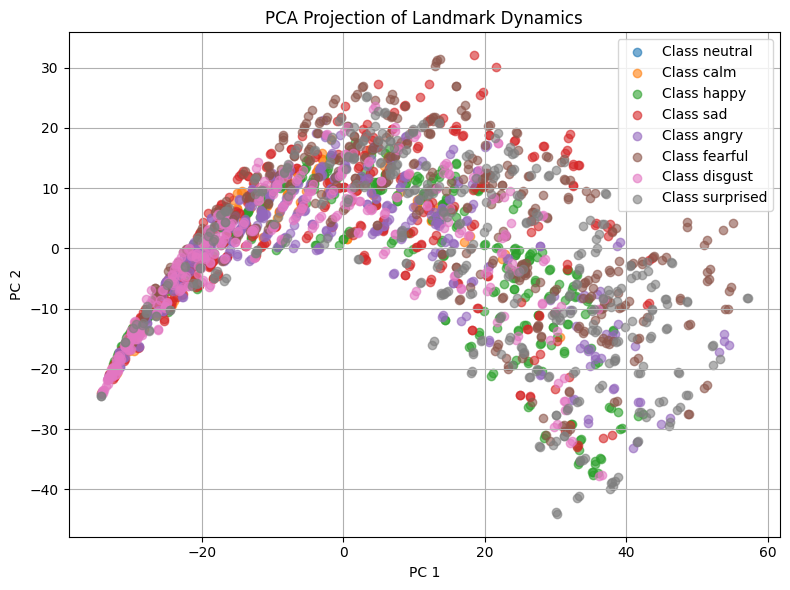

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_flat = padded_data.reshape(padded_data.shape[0], -1)

X_pca = PCA(n_components=2).fit_transform(X_flat)

# Plot for all classes
unique_labels = np.unique(all_labels)
plt.figure(figsize=(8, 6))

for emotion_idx in range(len(emotions)):
    plt.scatter(
        X_pca[all_labels == emotion_idx, 0],
        X_pca[all_labels == emotion_idx, 1],
        label=f'Class {emotions[emotion_idx]}',
        alpha=0.6
    )

plt.title('PCA Projection of Landmark Dynamics')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

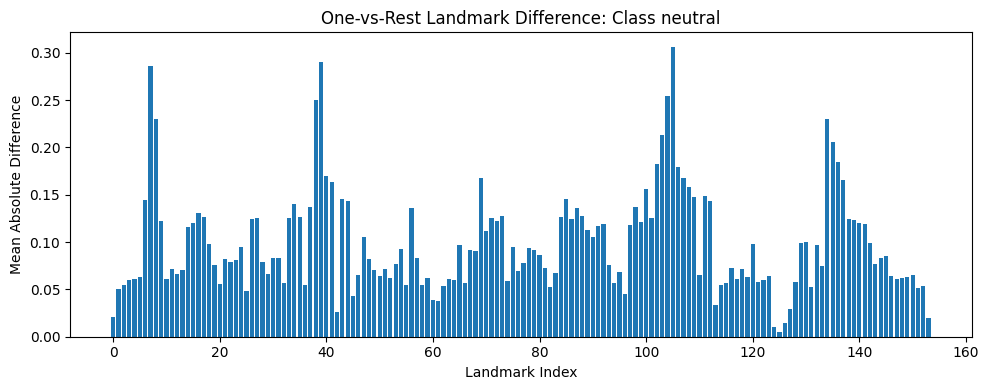

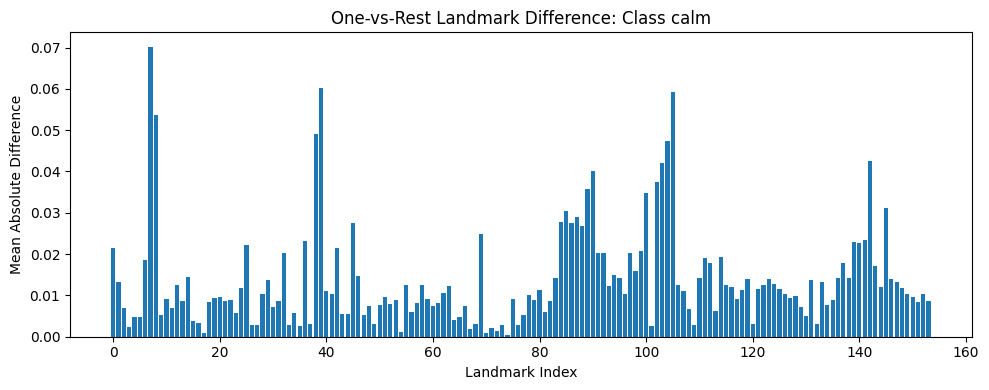

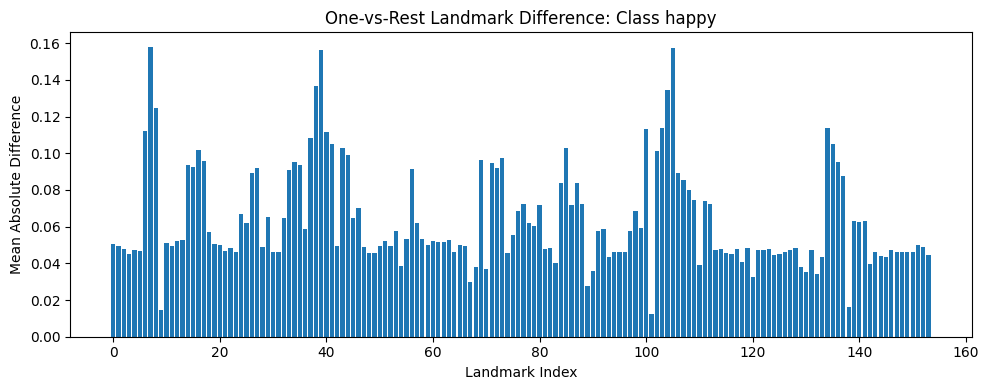

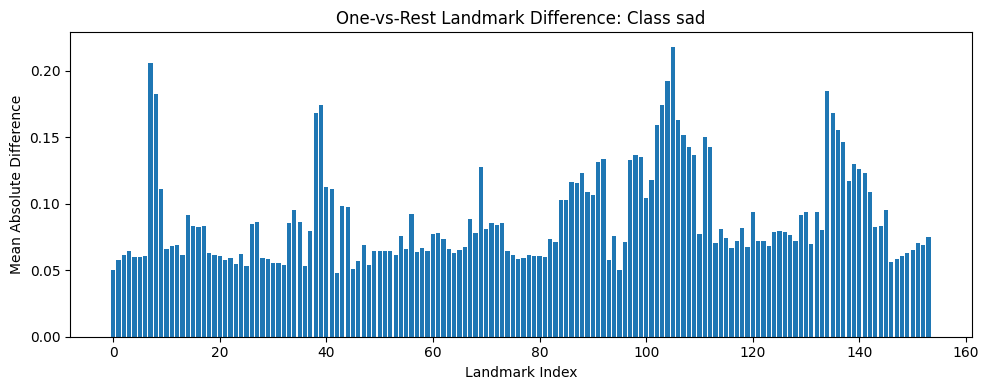

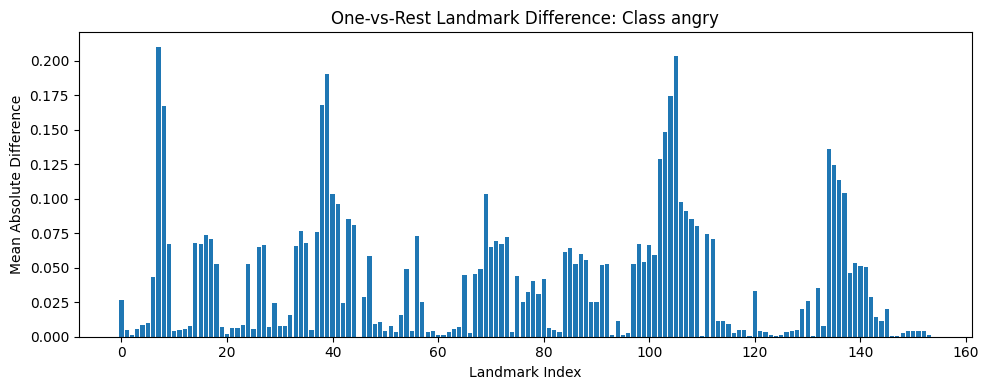

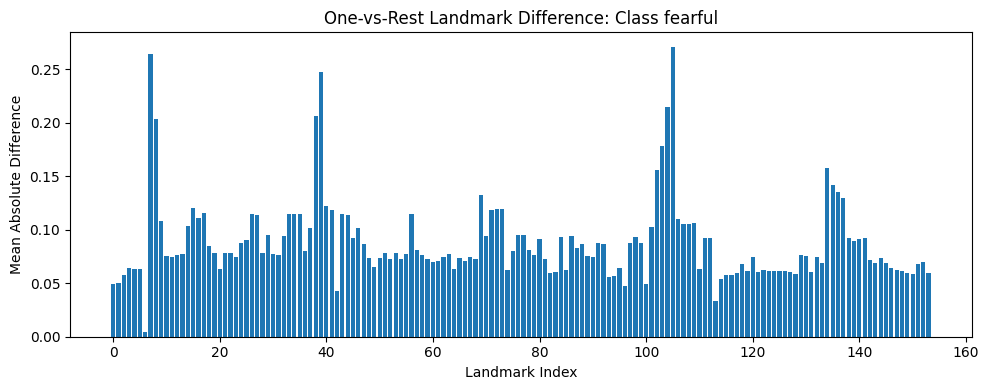

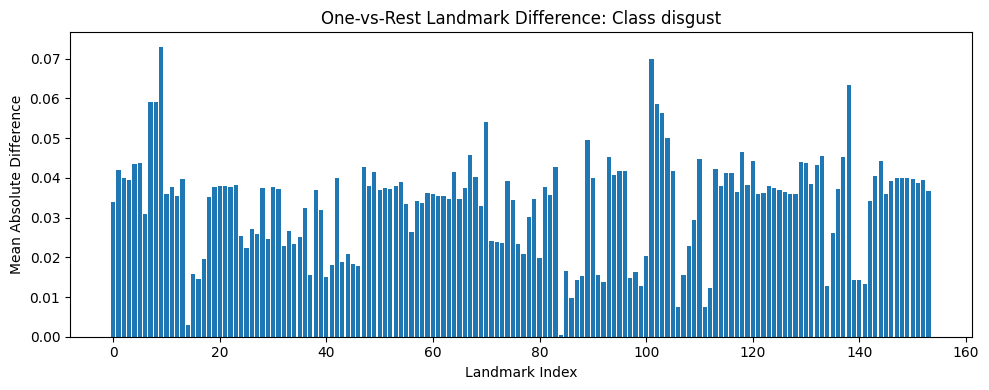

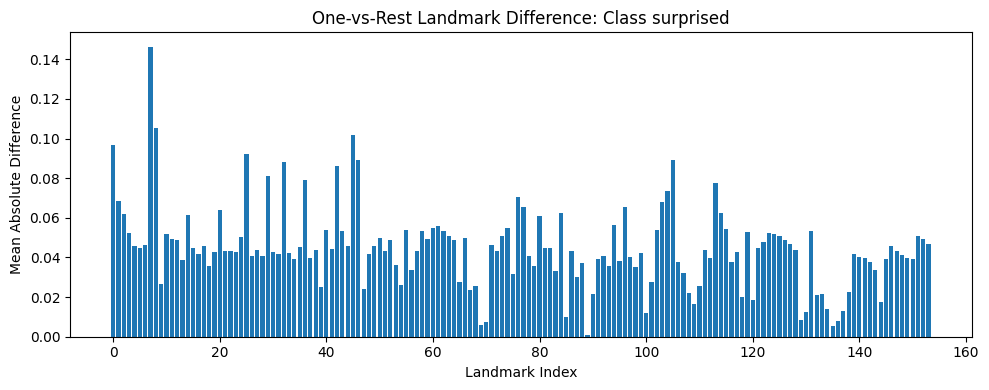

In [49]:
import numpy as np
import matplotlib.pyplot as plt

n_classes = len(emotions)
n_landmarks = 154

class_means = padded_data.mean(axis=1)

for i in range(n_classes):
    class_i_mean = class_means[i]
    
    rest_mean = np.delete(class_means, i, axis=0).mean(axis=0)
    
    diff_per_landmark = np.abs(class_i_mean - rest_mean)
    
    plt.figure(figsize=(10, 4))
    plt.bar(range(n_landmarks), diff_per_landmark)
    plt.xlabel('Landmark Index')
    plt.ylabel('Mean Absolute Difference')
    plt.title(f'One-vs-Rest Landmark Difference: Class {emotions[i]}')
    plt.tight_layout()
    plt.show()
